In [1]:
# Import packages
import pandas as pd       
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt 
import numpy as np
import xgboost as xgb
import pickle

In [2]:
def xgboost_model(X_train, y_train, X_test, y_test):
    # XGBoost (different learning rate) -- WE HAVE TO CHOOSE OVER WHICH PARAMETERS WE CROSS VALIDATE
    learning_rate_range = np.arange(0.01, 1, 0.05)
    n_estimators_range = np.arange(100, 1100, 100)
    test_XG = [] 
    train_XG = []
    max_score = 0
    for lr in learning_rate_range:
        for n_est in n_estimators_range:
            xgb_classifier = xgb.XGBClassifier(eta = lr, objective = 'binary:logistic', n_estimators = n_est, device = 'cuda') 
            xgb_classifier.fit(X_train, y_train)
            train_XG.append(xgb_classifier.score(X_train, y_train))
            test_XG.append(xgb_classifier.score(X_test, y_test))
            if test_XG[-1] > max_score:
                max_score = test_XG[-1]
                bst = xgb_classifier
    
    return bst

In [3]:
space = dict()
space['subsample'] = [0.25, 0.5, 0.75, 1.0] # row sampling
space['colsample_bytree'] = [0.25, 0.5, 0.75, 1.0] # column sampling
space['colsample_bylevel'] = [0.25, 0.5, 0.75, 1.0] # column sampling at each split

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from zmq import device


def tune_xgboost(X, y, space, n_estimators=500, balance=False):
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scoring = 'roc_auc'
    # TODO : discuss if this is the best metric, ('accuracy', 'roc_auc', 'f1', 'precision', 'recall')

    # find total negative and positive samples 
    total = len(y)
    total_positive = np.sum(y==1)
    total_negative = total - total_positive
    
    # TODO: discuss if it makes sense to train with this parameter for unbalanced dataset 
    # could be that in the future there is another inbalance

    # set the scale pos weight
    scale_pos_weight = total_negative / total_positive if balance else 1

    # print total positive % and total negative %, and scale pos weight (all rounded)
    print(f'Total positive : {round(100*(total_positive/total), 3)}%')
    print(f'Total negative : {round(100*(total_negative/total), 3)}%')
    print(f'Scale pos weight: {round(scale_pos_weight, 3)}')

    # define the model
    model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=n_estimators, device='cuda')
    # define search
    search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv)
    # execute search
    result = search.fit(X, y)
    
    # plot results
    results_df = pd.DataFrame(result.cv_results_)
    for key, values in space.items():
        
        # group the results by the hyperparameter
        param_means = []
        param_stds = []
        for value in values:
            mask = results_df['param_' + key] == value
            param_means.append(np.mean(results_df[mask]['mean_test_score']))
            param_stds.append(np.std(results_df[mask]['mean_test_score']))

        # create plot with two subplots side by side
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(key)
        ax[0].plot(values, param_means)
        ax[0].set_title('Mean test scores')
        ax[0].set_xlabel(key)
        ax[0].set_ylabel('mean scores')
        padding = 0.1
        ax[0].set_ylim(max(0, min(param_means) - padding), min(1, max(param_means) + padding))

        ax[1].plot(values, param_stds)
        ax[1].set_title('Mean score std')
        ax[1].set_xlabel(key)
        ax[1].set_ylabel('score std')
        padding = 0.05
        ax[1].set_ylim(max(0, min(param_stds) - padding), min(1, max(param_stds) + padding))

        plt.show()

    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters:')
    for k, v in result.best_params_.items():
        print('%s: %s' % (k, v))

    # best model
    best_model = result.best_estimator_

    return result.best_params_, best_model

In [5]:
# import data
data = pd.read_csv('../../data/datasetlabel.csv')
data['date'] = pd.to_datetime(data['date'])

# load selected features with pickle
with open('../../data/selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)

In [8]:
start_date = pd.to_datetime('2008-01-01')
end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
training_features = selected_features[start_date]

# print the features
print(f'Training features:\n{training_features}')

X = training_data[training_features].copy()
y = training_data['target'].copy()
negative_mask = (y == -1)
y[negative_mask] = 0

Training features:
['CAPEI', 'equity_invcap', 'evm', 'pe_op_basic', 'pe_inc', 'ps', 'ptpm', 'roa', 'roe', 'aftret_equity', 'aftret_invcapx', 'GProf', 'capital_ratio', 'short_debt', 'fcf_ocf', 'lt_ppent', 'at_turn', 'rect_turn', 'pay_turn', 'adv_sale', 'stat_divyeld', 'prc', 'vol', 'retx', 'mktcap', 'MACD_index']


Total positive : 42.712%
Total negative : 57.288%
Scale pos weight: 1


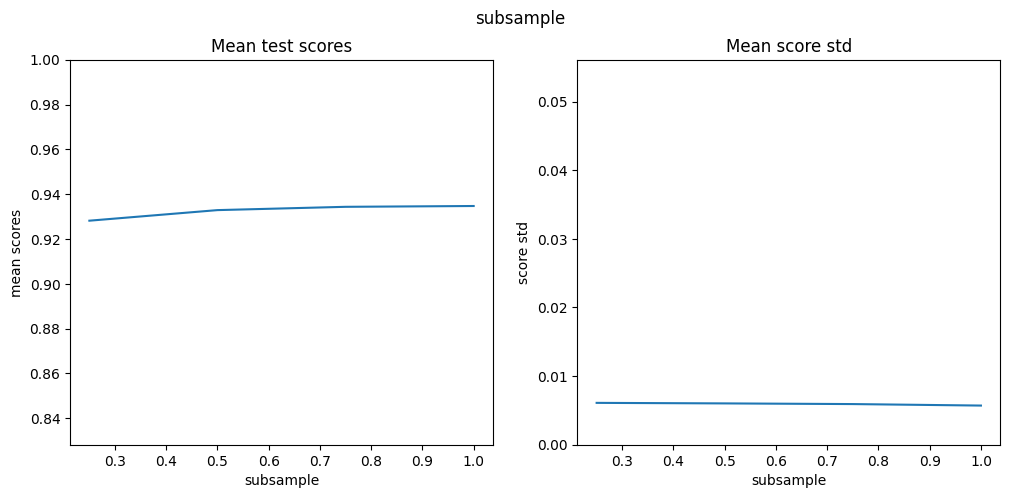

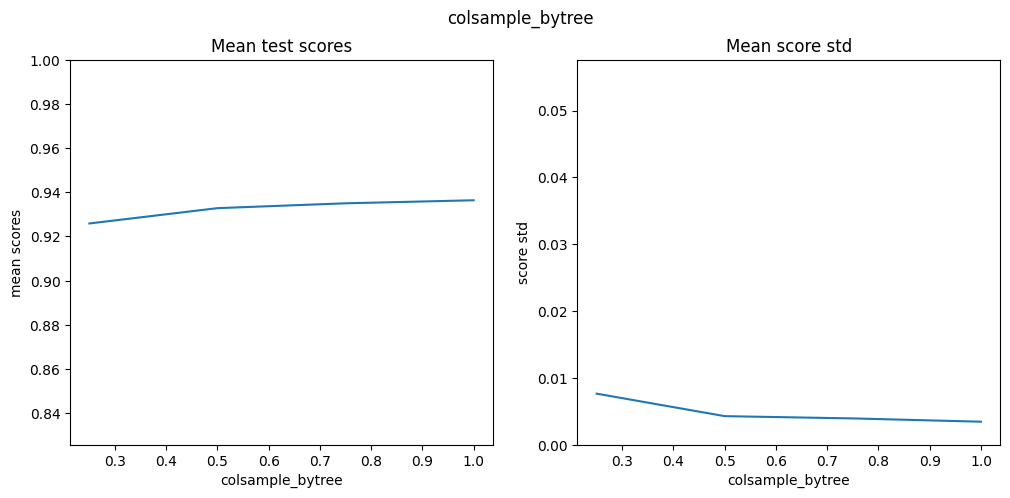

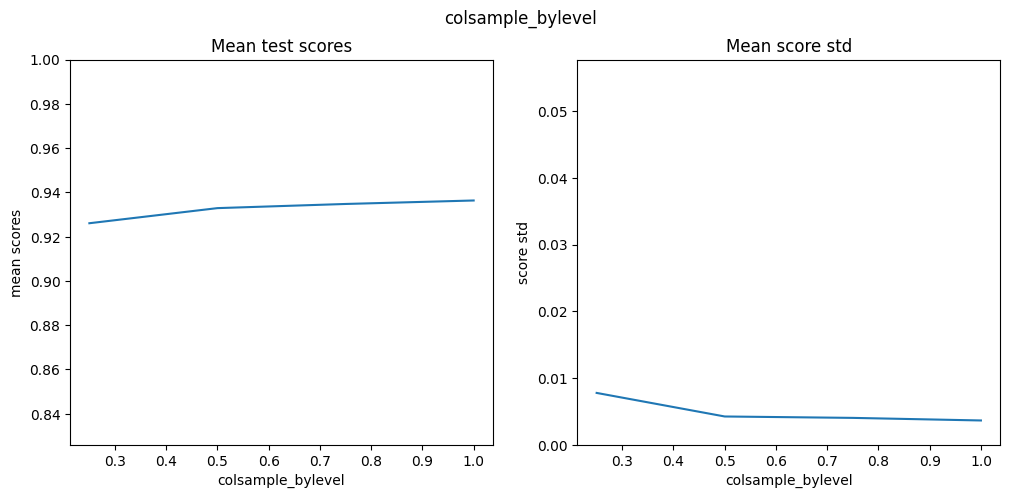

Best Score: 0.9406088501310016
Best Hyperparameters:
colsample_bylevel: 1.0
colsample_bytree: 1.0
subsample: 0.75


In [11]:
space = dict()
space['subsample'] = [0.25, 0.5, 0.75, 1.0] # row sampling
space['colsample_bytree'] = [0.25, 0.5, 0.75, 1.0] # column sampling
space['colsample_bylevel'] = [0.25, 0.5, 0.75, 1.0] # column sampling at each split

best_parameters, best_model = tune_xgboost(X, y, space, n_estimators=150, balance=False)

In [12]:
first_trading_date = start_date + pd.DateOffset(years=2)
dates = data['date'].unique()

# find the first trading day after the end date
while first_trading_date not in dates:
    first_trading_date += pd.DateOffset(days=1)

print(f'First trading date: {first_trading_date}')

X_prediction_mask = data['date'] == first_trading_date
X_prediction = data[X_prediction_mask][training_features].copy()
assert len(X_prediction) > 0, 'No data to predict'
permnos = data[X_prediction_mask]['permno'].copy()

First trading date: 2010-01-04 00:00:00


In [13]:
# find the predictions
y_pred_proba = best_model.predict_proba(X_prediction)
y_pred = best_model.predict(X_prediction)

# put the predictions in a dataframe
predictions_df = pd.DataFrame({
    'permno': permnos,
    '0_probability': y_pred_proba[:, 0],
    '1_probability': y_pred_proba[:, 1],
    'prediction': y_pred
})

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

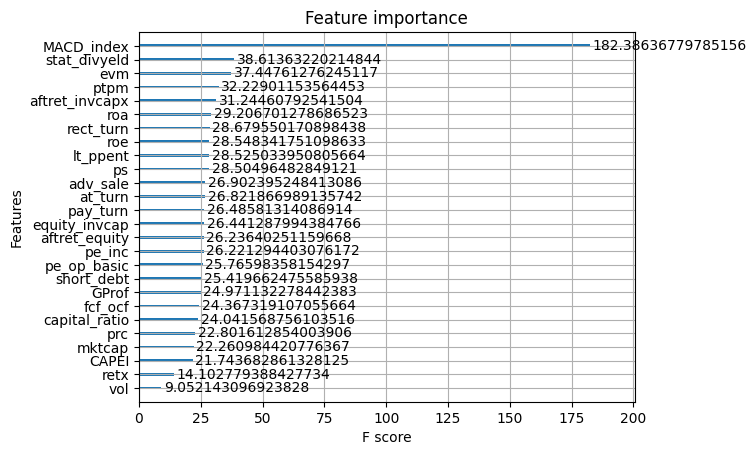

In [20]:
# gain is usually the most realiable metric to evaluate the importance of the features
xgb.plot_importance(best_model, importance_type='gain')

In [14]:
predictions_df.head()

,permno,0_probability,1_probability,prediction
2386,10078,0.251691,0.748309,1
4795,10104,0.039799,0.960201,1
10710,10107,0.185050,0.814950,1
16625,10137,0.730308,0.269692,0
19308,10138,0.072476,0.927524,1


In [15]:
n = 15
# find the n argmin and argmax
top_n = predictions_df['1_probability'].nlargest(n)
bottom_n = predictions_df['1_probability'].nsmallest(n)

print(f'Top {n} long predictions:')
print(predictions_df.loc[top_n.index])
print('-'*58)
print(f'Top {n} short predictions:')
print(predictions_df.loc[bottom_n.index])

Top 15 long predictions:
         permno  0_probability  1_probability  prediction
1110147   39490       0.001388       0.998612           1
3278302   91233       0.001775       0.998225           1
2813357   86783       0.002802       0.997198           1
2352185   79915       0.005805       0.994195           1
443545    17144       0.005886       0.994114           1
3235754   90829       0.006380       0.993620           1
2949027   88352       0.007121       0.992879           1
2461289   81774       0.007672       0.992328           1
1469785   53613       0.008010       0.991990           1
2246514   78877       0.008199       0.991801           1
2191655   77606       0.008480       0.991520           1
1800079   66384       0.008846       0.991154           1
2909927   87657       0.008950       0.991050           1
1526822   57817       0.009119       0.990881           1
2944916   88313       0.011314       0.988686           1
-----------------------------------------------